Libraries to be imported

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import clear_output
import gym
from time import sleep


Environment creation

In [23]:
# Initialisation
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()
frame = env.render()


Animation 

In [24]:
# Animation helper function
def animationVisual(animationFrames):
    '''
    Creates an animation.

    Parameters:
    animationFrames (list): A list of frames for the animation.

    Returns:
    None
    '''
        

    # Define parameters
    fps = 5   # Frames per second
    interval = 50  # Frame interval
    dpi = 300  

    frames = []
    for frame in animationFrames:
        frames.append(frame['frame'])

    # Frame size configuration
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    # Animation 
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=interval)

    # Define time delay between frames
    frameDelay = 0.05 
    for frame in animationFrames:
        clear_output(wait=True)
        plt.imshow(frame['frame'])
        plt.axis('off')
        plt.show()

        print(f"Episode: {frame['episode']}/{animationFrames[-1]['episode']}")
        print(f"Epoch: {frame['epoch']}/{animationFrames[-1]['epoch']}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        # animation freeze
        sleep(frameDelay)

Training the agent

In [25]:
# Training function

def trainTaxi(numEpisodes, alpha, gamma):
    '''
    Using Q-Learning to train a RL agent for Taxi-v3 environment

    Args:
    - numEpisodes (int): Number of training episodes.
    - alpha (float): Learning rate for Q-learning update.
    - gamma (float): Discount factor for future rewards.

    Returns:
    - q_table (numpy.ndarray): Learned Q-table.
    - reward_list (list): List of total rewards obtained per episode during training.
    - failed_delivery_list (list): List of total failed deliveries.
    '''

    # Initializing Q table
    actions = env.action_space.n
    states = env.observation_space.n
    q_table = np.zeros((states, actions))
    
    # Hyperparameters
    reward_list = []
    failed_delivery_list = []
    epsilon = 0.1
    for episode in range(numEpisodes):
        # Initalize episode variables
        state, info = env.reset()
        episode_reward = 0
        failedDeliveries = 0
        # Running one episode
        while True:
            # Epsilon greedy implementation
            if np.random.uniform(0, 1) < epsilon:
                # Exploration
                action = env.action_space.sample()
            else:
                # Exploitation
                action = np.argmax(q_table[state])

            # Implementing Q learning function    
            newState, reward, done, _, info = env.step(action)
            oldVal = q_table[state, action]
            nextMax = np.max(q_table[newState])
            newVal = (1 - alpha) * oldVal + alpha * (reward + gamma * nextMax)
            q_table[state, action] = newVal
            
            # Update state and failed deliveries count
            state = newState
            if reward == -10:
                failedDeliveries += 1
                
            episode_reward += reward
            
            if done:
                break
        # Appending rewards and deliveries into empty list
        reward_list.append(episode_reward)
        failed_delivery_list.append(failedDeliveries)
        
        if (episode + 1) % 100 == 0:
            print(f"Episode: {episode + 1} out of: {numEpisodes}, Reward: {episode_reward}, Failed Deliveries: {failedDeliveries}")
    
    return q_table, reward_list, failed_delivery_list


Episode: 100 out of: 10000, Reward: -333, Failed Deliveries: 11
Episode: 200 out of: 10000, Reward: -265, Failed Deliveries: 14
Episode: 300 out of: 10000, Reward: -87, Failed Deliveries: 5
Episode: 400 out of: 10000, Reward: -11, Failed Deliveries: 1
Episode: 500 out of: 10000, Reward: -15, Failed Deliveries: 1
Episode: 600 out of: 10000, Reward: 8, Failed Deliveries: 0
Episode: 700 out of: 10000, Reward: -11, Failed Deliveries: 2
Episode: 800 out of: 10000, Reward: -17, Failed Deliveries: 2
Episode: 900 out of: 10000, Reward: 10, Failed Deliveries: 0
Episode: 1000 out of: 10000, Reward: 1, Failed Deliveries: 0
Episode: 1100 out of: 10000, Reward: 8, Failed Deliveries: 0
Episode: 1200 out of: 10000, Reward: 11, Failed Deliveries: 0
Episode: 1300 out of: 10000, Reward: 7, Failed Deliveries: 0
Episode: 1400 out of: 10000, Reward: 14, Failed Deliveries: 0
Episode: 1500 out of: 10000, Reward: -4, Failed Deliveries: 1
Episode: 1600 out of: 10000, Reward: -9, Failed Deliveries: 1
Episode: 1

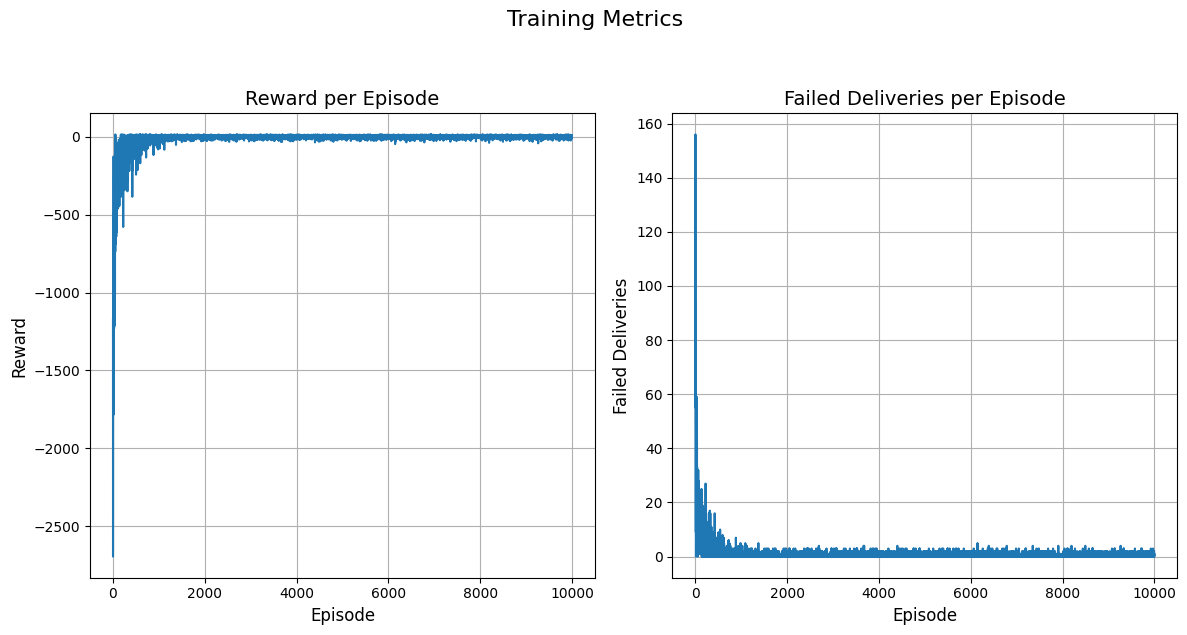

In [26]:
# Hyperparameters
numEpisodes=10000
alpha=0.1
gamma=1.0

# Run the training function
q_table, reward_list, failed_delivery_list = trainTaxi(numEpisodes,alpha,gamma)

# Plot metrics from train function
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Training Metrics', fontsize=16, y=1.05)
# First subplot
axs[0].plot(reward_list)
axs[0].set_xlabel("Episode", fontsize=12)
axs[0].set_ylabel("Reward", fontsize=12)
axs[0].set_title("Reward per Episode", fontsize=14)
axs[0].grid(True)
# Second subplot
axs[1].plot(failed_delivery_list)
axs[1].set_xlabel("Episode", fontsize=12)
axs[1].set_ylabel("Failed Deliveries", fontsize=12)
axs[1].set_title("Failed Deliveries per Episode", fontsize=14)
axs[1].grid(True)
plt.tight_layout()

# Show plot
plt.show()

Testing the agent

In [27]:
# Testing fucntion

def runSimulation(env, q_table, numEpisodes, numRepetitions):
    '''
    This function runs a simulation of our trained RL agent and animates it

    Args:
    - env: environment to be simulated
    - q_table: the Q-table used to make decisons in the simulation
    - numEpisodes: number of episodes to be simulated
    - numRepitions: number of times to repeat the simulation 

    Returns:
    None
    '''
    # Repeat so you can watch the magic twice !
    for repetitionCount in range(numRepetitions):
        # Initializing variables
        animationFrames = []
        failedDeliveries = 0
        epochNum = 0

        # Performing one simulation
        my_env = env.reset()
        state = my_env[0]
        rewards = 0
        done = False
        episode = 1

        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, _, _ = env.step(action)
            rewards += reward

            # Check for failed deliveries
            if reward == -10:
                failedDeliveries += 1

            # Store rendered frame in animation dictionary
            animationFrames.append({'frame': env.render(), 'episode': episode, 'epoch': epochNum + 1,
                'state': state,
                'action': action,
                'reward': rewards
                }
            )

            epochNum += 1

        # Running the animation
        animationVisual(animationFrames)

        print("\n")
        # Printing testing results to screen 
        print(f"Test results after {numEpisodes} episodes:")
        print(f"Average number of epochs per episode {epochNum / numEpisodes}")
        print(f"Average failed drop-offs per episode: {failedDeliveries / numEpisodes}")


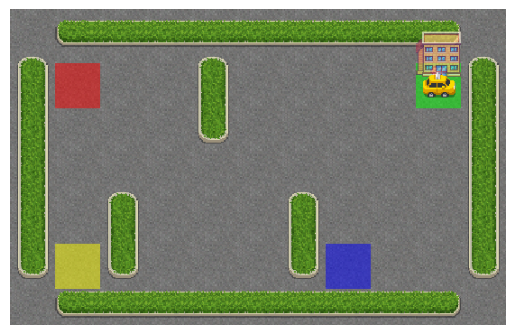

Episode: 1/1
Epoch: 16/16
State: 85
Action: 5
Reward: 5


Test results after 1 episodes:
Average number of epochs per episode 16.0
Average failed drop-offs per episode: 0.0


In [28]:
# Hyperparameters
numEpisodes = 1
numRepetitions = 1

# Run simulation 
runSimulation(env, q_table, numEpisodes=1, numRepetitions=2)
